# <center>Teorijski uvod</center>

**BERT** (Bidirectional Encoder Representations from Transformers) predstavlja model mašinskog učenja za rešavanje raznovrsnih problema u okviru obrade prirodnog jezika (NLP). Razvijen je 2018. godine od strane istraživača Google-a kao open-souce projekat i aktivno se koristi u okviru proizvoda ove kompanije. Izvanredni rezultati koje je ovaj model postigao na referentnim zadacima različite prirode (GLUE, SQuAD v1.1, SWAG, MultiNLI itd.), podstakle su njegovu široku primenu. 

Dugo vremena su se za obradu prirodnog jezika koristile rekurentne neuronske mreže (najčešće LSTM) koje su podatke obrađivale sekvencijalno s leva na desno ili obratno.  Iako intuitivno više smisla ima uzeti u obzir i prethodni i naredni deo rečenice istovremeno prilikom određivanja konteksta određene reči, to zbog arhitekture rekurentnih mreža nije moguće. 

BERT model donosi novine, koje će ovakav vid procesiranja prirodnog jezika učiniti mogućim. On koristi transformere čija je uloga da modeluju odnose između reči u datom kontekstu. Njihova arhitektura bazirana na enkoderima i dekoderima. Za problem modelovanja jezika značajan je samo enkoder.

## <center>Transformeri</center>

Kako bi uvođenje BERT modela bilo moguće neophodno je kratko objasniti kako transformeri funkcionišu. Svaki enkoder se sastoji iz dve komponente: mehanizam pažnje i neuronska mreža sa propagacijom u napred. Mehanizam pažnje prihvata reprezentacije prethodnih enkodera i računa njihove težinske sume, čime se određuju međusobni uticaji i odnosi reči u rečenici. Neuronska mreža sa propagacijom u napred zatim procesira svaki od ovih izlaza pojedinačno. Ovakvi izlazi se dalje prosleđuju enkoderima u sledećem sloju koji ih prihvataju kao svoje ulaze. Prvi enkoder prihvata podatke vezane za poziciju kao i numeričku reprezentaciju reči, dok ostali prihvataju enkodirane vektore prethodnog sloja. Ovakva arhitektura omogućava da se apstraktni smisao ciljne reči odredi na osnovu teksta koji se nalazi pre i posle nje, nasuprot pristupu rekurentnih mreža.

Pre prosledjivanja informacije enkoderima potrebno je konvertovati tekst u zapis razumljiv računarima. Kodiranje se vrši tako da se svakoj reči dodeli numerički zapis, pri čemu je očuvana informacija o poziciji svake reči u rečenici kako bi enkoderi mogli da je koriste. Ovaj postupak se naziva poziciono kodiranje, zarad čega se kodirani vektor koji predstavlja tekst sabira sa vektorom iste dužine koji nosi informaciju o poziciji svake reči u datom tekstu.

Zadatak svakog sloja enkodera jeste da kreira numeričku reprezentaciju reči koja sadrži informaciju o vezama sa ostalim delovima ulaza. Da bi se to postiglo, nad jedinicama koje računaju linearnu kombinaciju svojih ulaza, primenjuje se skalirani skalarni proizvod. Kada se rečenica prosledi modelu, parametri jedinica se računaju između svake reči istovremeno. Njihov zadatak je da proizvedu numerički zapis reči u zavisnosti od konteksta u rečenici, tako da sadrži informaciju o samoj reči koju predstavlja zajedno sa težinskom sumom drugih reči koje su sa njom u datom kontekstu povezane. Za svaku jedinicu u sloju postoje tri težinske matrice: $W_{Q}$ - težine upita (query), $W_{K}$ - težine ključa (key), $W_{V}$ - težine vrednosti (value). Množenjem ulaza jedinica ovim matricama dobijaju se odgovarajući vektori: $q_i = x_iW_{Q}$ - vektor upita, $k_i = x_iW_{K}$ - vektor ključa, $v_i = x_iW_{V}$ - vektor vrednosti, gde $x_i$ predstavlja ulaz. Težine jedinica dobijaju se preko vektora upita i ključa. Težina $a_{ij}$ za uticaj reči $i$ na reč $j$ jeste skalarni proizvod $q_i$ i $k_j$. Kako bi se gradijenti stabilizovali vrednost težine se deli korenom dužine vektora ključa - $\sqrt{d_k}$. Potrebno je naglasiti da to što npr. reč $i$ utiče znajačno ili minimalno na reč $j$, ne mora da važi i u suprotnom pravcu, već uticaj može biti asimetričan. Izlaz jedinice za reč $i$ je težinska suma vektora vrednosti svih reči, pri čemu su težine $a_{ij}$ uticaj reči $i$ na ostale reči.  
Račun za međusobne uticaje može se pojednostaviti sledećim zapisom:  

$A(Q, K, V) = softmax(\frac{QK^{T}}{\sqrt{d_k}})V$  

gde su matrice Q, K, V takve da su im $i$-ti redovi zapravo vektori $q_i, k_i, v_i$ redom. Matrica A je sastavljena od elemenata $a_{ij}$. 

Jedan skup matrica ($W_Q$, $W_K$, $W_V$) čini glavu mehanizma pažnje, a u svakom sloju modela postoji više ovakvih glava. Svaka od njih omogućava da se modeluju različite vrste uticaja i odnosa koje bivaju naučene tokom treninga modela. Često su ti uticaji prirodni i razumljivi čoveku ali to ne mora nužno biti pravilo. Računanje ovih uticaja mogu se vršiti paralelno što povećava efikasnost. Arhitektura enkodera je prikazana na sledećoj slici. 

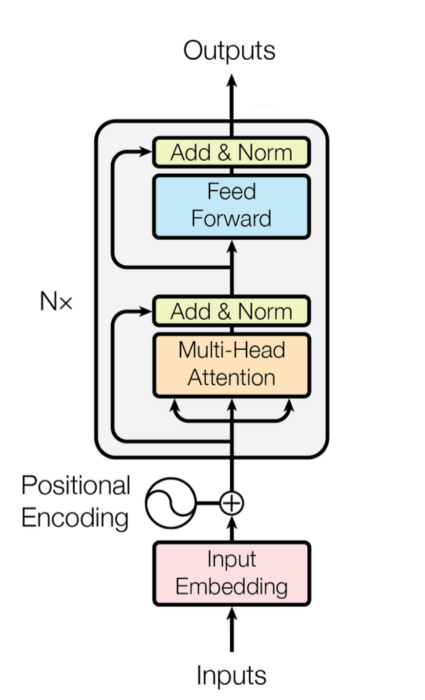



## <center>BERT</center>

Oslanjajući se na transformere, BERT model se pre-trenira nad izuzetno velikim količinama sirovih tekstualnih podataka. To se čini metodama nevođenog učenja i cilj je da model nauči da "razume" željeni prirodni jezik. Postupak podrazumeva kombinovanje dve metode: modelovanjem uz pomoć maski i predviđanjem naredne rečenice, pri čemu se ove dve metode primenjuju istovremeno.

Modelovanje uz pomoć maski se zasniva na tome da se $15\%$ reči u svakoj rečenici zameni tokenom $[MASK]$. Model tada pokušava da koristeći preostale dostupne reči na osnovu konteksta odredi maskirane reči. Predviđanje ovih reči zahteva dodavanje potpuno povezane mreže koja kao ulaze dobija vrednosti poslednjeg sloja enkodera. Njen zadatak jeste da vrši klasifikaciju. Nakon toga se dobijene vektorske vrednosti prevode u reči i računaju se verovatnoće maskirane reči (iz dostupnog vokabulara) korišćenjem $softmax$ aktivacije. Naredna slika grafički prikazuje opisani postupak.

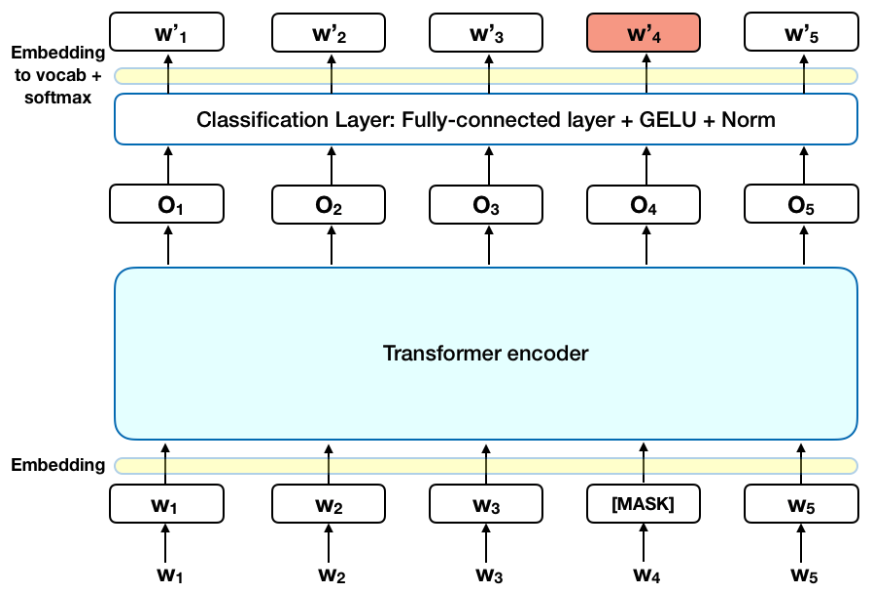

Funkcija greške klasifikacije uzima u obzir samo predikcije maskiranih reči, dok ostale zanemaruje. Bitno je napomenuti da se zarad regularizacije ne maskira svih $15\%$ reči tokenom $[MASK]$. Većina njih (~ $80\%$) će biti zamenjena ovim tokenom ali će jedan deo (~ $10\%$) biti zamenjen proizvoljnim rečima iz vokabulara, dok će drugi deo (~ $10\%$) biti zamenjen stvarnim rečima koji se na toj poziciji nalaze. Na taj način se podstiče korektno enkodiranje reči uz pristrasnost ka ispravnom predviđanju.

Predviđanje naredne rečenice zasniva se na tome da model prihvata parove rečenica među kojima je njih $50\%$ ispravno nadovezano dok je drugih $50\%$ nasumično nadovezano. Pretpostavka nasumične nadovezanosti jeste da takve dve rečenice neće činiti smislenu celinu. Cilj je da se model istrenira da prepoznaje da li se rečenice prirodno nadovezuju. Kako bi ovo bilo moguće ulaz se procesira na sledeći način. Na početak se dodaje token $[CLS]$ koji označava početak para rečenica koji će na izlazu davati informaciju o tome da li se rečenice prirodno nadovezuju. Na kraju svake rečenice dodaje se token $[SEP]$ koji predstavlja separator, odnosno signalizira kraj tekuće rečenice. Nakon tranformacije rečenice u numerički vektorski zapis ona se prosledjuje transformeru. Izlaz $[CLS]$ tokena predstavlja vektor, korišćenjem sloja za klasifikaciju sa $softmax$ aktivacijom se dobijaju verovatnoće da li se rečenice prirodno nadovezuju ili ne. Naredna slika grafički prikazuje opisani postupak.

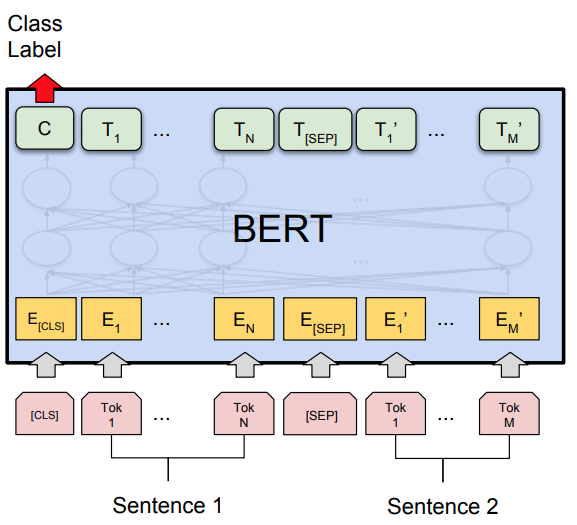

Prilikom pre-treniranja BERT modela modelovanje uz pomoć maski i predviđanje naredne rečenice se vrše istovremeno pri čemu je cilj minimizovati ukupnu grešku koju ove dve metode prave. Faza pre-treniranja na specijalizovanom hardveru velike računske moći traje oko 4 dana. Ovu fazu nije potrebno izvršavati, već su dostupni gotovi modeli kod kojih je pre-treniranje već obavljeno i pristupa se finom podešavanju za rešavanje konkretnog problema obrade prirodnog jezika. Ovakvi modeli su memorijski zahtevni zbog velikog broja parametara i postoje u dva oblika: osnovni (~ 110 miliona parametara) i prošireni (~ 340 miliona parametara). Izbor jednog od ova dva modela se svodi na nagodbu između performansi rešavanja problema i memorijske/vremenske zahtevnosti. 

Nakon završetka faze pre-treniranja modela da "razume" prirodni jezik sa kojim će se raditi, pristupa se fazi podešavanja BERT modela za konkretan problem sa kojim će biti suočen. Ti problemi mogu biti: analiza sentimenta, mašinsko odgovaranje na pitanja, predviđanje teksta, generisanje teksta, sumarizacija, itd. Za ovaj rad je od značaja primena u oblasti analize sentimenta teksta, odnosno klasifikacije toksičnih komentara. Prilagođavanje BERT modela za ovaj zadatak može se učiniti na sličan način kao kod predviđanja naredne rečenici dodavanjem klasifikacionog sloja koji obrađuje izlaz $[CLS]$ tokena iz poslednjeg sloja dekodera.

## <center>DistilBERT (Distilled BERT)</center>

Kao što je u prethodnom delu opisano, BERT modeli doneli su značajan napredak u pogledu rešavanja problema obrade prirodnog jezika, ali problemi postoje. Naime, već je navedeno da je ovaj model računski i memorijski zahtevan, a uz sve to treba dodati i vreme potrebno za treniranje. Postavlja se pitanje kako dobiti kompaktnu formu ovog modela koja će zauzimati manje prostora i brže se izvršavati, a da se pri tome u većoj meri očuvaju njegove performanse prilikom rešavanja zadataka. Jedan od načina da se to učini jeste primena destilacije pri čemu se dobija **DistilBERT** model.

Destilacija modela je opštiji koncept koji nalazi primenu i u drugim algoritmima mašinskog učenja. Ideja se zasniva na tome da postoje dva modela: jedan istrenirani veći model (učitelj), koji u ovom slučaju predstavlja standardni BERT i jedan kompaktniji model (učenik), koji se trenira tako da oponaša veći model i on u ovom slučaju predstavlja DistilBERT. Iako model učenik može imati drugačiju arhitekturu, najčešće se uzima ista kao kod modela učitelja odnosno BERT modela. Razlika je u tome što će model učenik imati značajno manji broj enkodera u svojoj strukturi. Treniranje modela učenika tako da oponaša model učitelja nameće se adekvatno zadatom greškom u odnosu na koju se model optimizuje. Pored minimizacije standardne greške klasifikacije (unakrsna entropija) koju i model učitelja minimizuje, neophodno je dodati grešku koja će prouzrokovati slično ponašanje ova dva modela. Jedan način da se ova greška formuliše jeste korišćenjem verovatnoća dobijenih $softmax$ funkcijom za izlaze modela učitelja i modela učenika. Neka je $T(x) = softmax(\hat{t}_1, ..., \hat{t}_n) = (t_1, ..., t_n)$ izlaz modela učitelja, a $S(x) = softmax(\hat{s}_1, ..., \hat{s}_n) =(s_1, ..., s_n)$ izlaz modela učenika. Greška koja minimizuje razlike između raspodela $T$ i $S$ definisana je kao : $L = -\sum_{i = 1}^{n} t_i \cdot log(s_i)$. Sada je ukupna greška koja treningom treba da se minimizuje jednaka zbiru greške klasifikacije za problem koji se rešava i greške koja kvantifikuje razliku raspodela $T$ i $S$. Od značaja je definisati pojam temperature koji se koristi u $softmax$ funkciji. Jedna komponenta vektora na koji je primenjena $softmax$ funkcija jeste sledeći $t_i(\theta) = softmax(\hat{t}_1, ..., \hat{t}_n)_i = \frac{e^{\frac{\hat{t}_i}{\theta}}}{\sum_{j = 1}^{n} e^{\frac{\hat{t}_j}{\theta}}}$, gde je $\theta \geq 1$ parametar (koji se naziva temperatura). Za vrednost parametra $\theta = 1$ dobija se standardna $softmax$ funkcija, kada $\theta \to 0$ tada $T$ postaje indikator, dok kada $\theta \to +\infty$ tada $T$ teži uniformnoj raspodeli. Smisao $\theta$ jeste da se kontroliše glatkost raspodele verovatnoća. Prilikom treninga model učitelja i model učenika koriste isti parametar $\theta \geq 1$ dok se prilikom primene modela koristi parametar $\theta = 1$. Naredna slika grafički prikazuje opisani postupak.

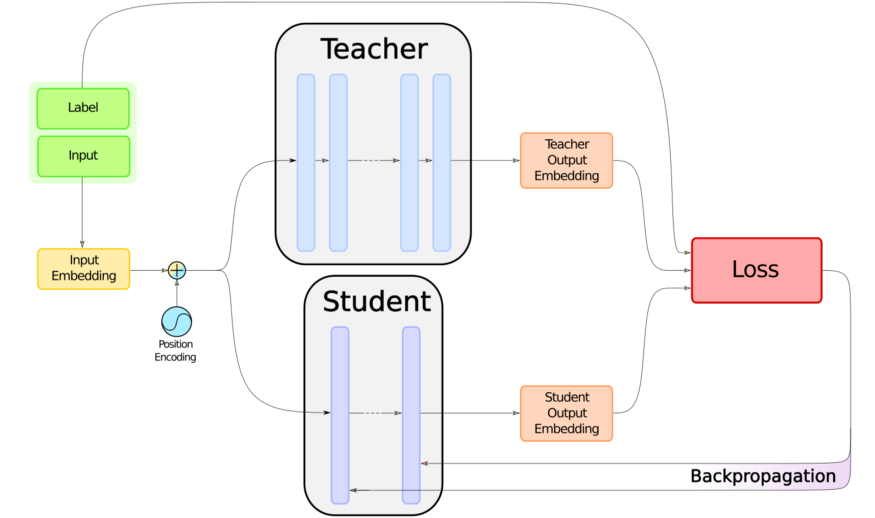

BERT model dobijen destilacijom standardnog modela odnosno DistilBERT čuva preko $95\%$ performansi polaznog modela, broj parametara je redukovan za $40\%$, a izvršavanje je $60\%$ brže. Time se omogućava efikasno korišćenje ovih modela na personalnim računarima i uređajima koji nemaju veliku računsku moć.